# Import Libraries

In [63]:
import pandas as pd
import numpy as np
import sidetable
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import feature_engine
import mlflow
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder)
from sklearn.compose import ColumnTransformer
from feature_engine.outliers.winsorizer import Winsorizer
from feature_engine.encoding import CountFrequencyEncoder

# Dispaly Setting

In [44]:
pd.set_option('display.max_columns', None)
sklearn.set_config(transform_output='pandas')

In [18]:
print(os.getcwd(),os.listdir('E:\\titanic-classification-dataset\\data'))

E:\titanic-classification-dataset\notebook ['.ipynb_checkpoints', 'test.csv', 'Titanic-Dataset.csv', 'train.csv']


# Read Data

In [19]:
train_df = pd.read_csv(r'E:\\titanic-classification-dataset\\data\\train.csv')
train_df = train_df.iloc[:,1:]
train_df.head()

,pclass,sex,age,fare,embarked,family,survived
0,3,female,17.0,7.9250,S,6,1
1,3,male,NaN,24.1500,Q,1,0
2,2,male,34.0,13.0000,S,0,0
3,3,male,59.0,7.2500,S,0,0
4,3,male,20.0,7.8542,S,0,0


In [20]:
test_df = pd.read_csv(r'E:\\titanic-classification-dataset\\data\\test.csv')
test_df = test_df.iloc[:,1:]
test_df.head()

,pclass,sex,age,fare,embarked,family,survived
0,3,male,28.0,56.4958,S,0,0
1,1,female,48.0,39.6000,C,1,1
2,3,male,32.0,15.8500,S,1,0
3,3,female,16.0,46.9000,S,7,0
4,3,female,18.0,9.8417,S,0,1


# Preliminary Analysis

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    712 non-null    int64  
 1   sex       712 non-null    object 
 2   age       577 non-null    float64
 3   fare      712 non-null    float64
 4   embarked  711 non-null    object 
 5   family    712 non-null    int64  
 6   survived  712 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 39.1+ KB


In [22]:
train_df.describe(include='all')

,pclass,sex,age,fare,embarked,family,survived
count,712.000000,712,577.000000,712.000000,711,712.000000,712.000000
unique,NaN,2,NaN,NaN,3,NaN,NaN
top,NaN,male,NaN,NaN,S,NaN,NaN
freq,NaN,458,NaN,NaN,520,NaN,NaN
mean,2.307584,NaN,29.651941,33.071640,NaN,0.928371,0.393258
std,0.836609,NaN,14.503764,52.265108,NaN,1.610159,0.488817
min,1.000000,NaN,0.420000,0.000000,NaN,0.000000,0.000000
25%,2.000000,NaN,21.000000,7.925000,NaN,0.000000,0.000000
50%,3.000000,NaN,28.000000,14.500000,NaN,0.000000,0.000000
75%,3.000000,NaN,38.000000,31.275000,NaN,1.000000,1.000000


# Target Variable

In [23]:
train_df['survived'].value_counts(normalize=True)

survived
0    0.606742
1    0.393258
Name: proportion, dtype: float64

- **Problem of imbalance classification**

In [24]:
train_df['survived'].describe()

count    712.000000
mean       0.393258
std        0.488817
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: survived, dtype: float64

# Missing Value Analysis

- **train data**

In [25]:
train_df.stb.missing()

,missing,total,percent
age,135,712,18.960674
embarked,1,712,0.140449
pclass,0,712,0.000000
sex,0,712,0.000000
fare,0,712,0.000000
family,0,712,0.000000
survived,0,712,0.000000


- **test data**

In [34]:
test_df.stb.missing()

,missing,total,percent
age,42,179,23.463687
embarked,1,179,0.558659
pclass,0,179,0.000000
sex,0,179,0.000000
fare,0,179,0.000000
family,0,179,0.000000
survived,0,179,0.000000


- **age and embarked** have missing values

# Outlier Analysis

In [26]:
col = ['age','fare']

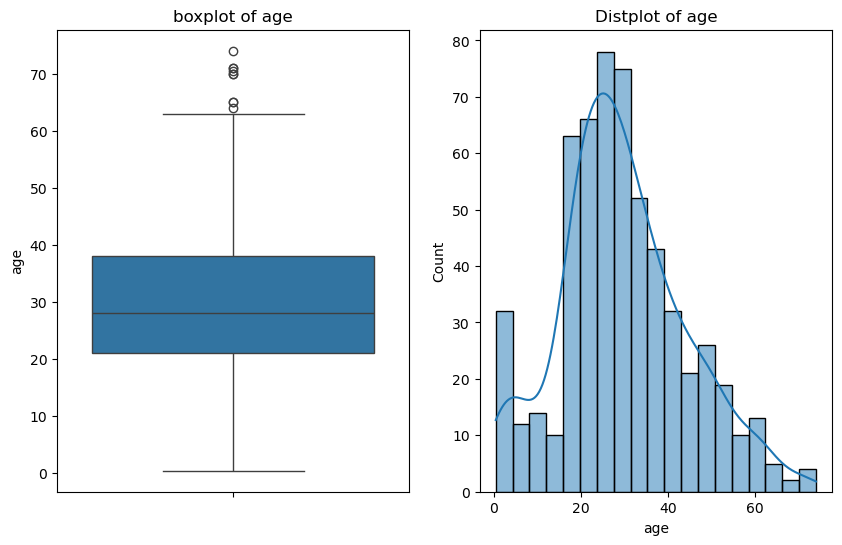

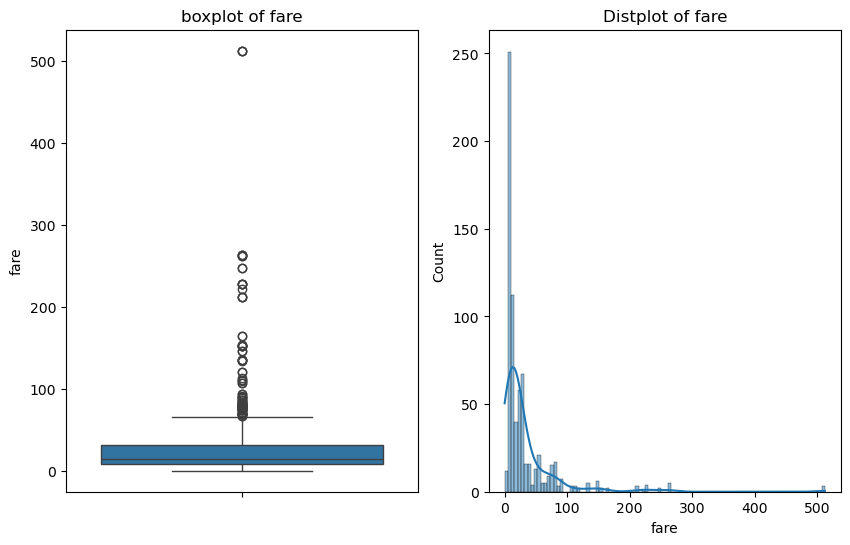

In [27]:
for i in col:
    fig,ax = plt.subplots(1,2,figsize=(10,6))
    sns.boxplot(train_df[i],ax=ax[0])
    ax[0].set_title('boxplot of '+ i)
    
    
    sns.histplot(train_df[i],ax=ax[1],kde=True)
    ax[1].set_title('Distplot of ' +i)
    plt.show()

- **age** has outlier and it follows kind of gaussian distribution, will use gaussian outlier treatment.
- **fare** has outlier and it doesn't follow gaussian distribution, will use IQR outlier treatment. 

# Pipeline for Individual Features

In [28]:
pd.DataFrame({'Feature_dtype':train_df.dtypes,'Features_nunique':[train_df[col].nunique() for col in train_df.columns]})

,Feature_dtype,Features_nunique
pclass,int64,3
sex,object,2
age,float64,84
fare,float64,228
embarked,object,3
family,int64,9
survived,int64,2


In [39]:
age_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('outlier', Winsorizer(capping_method='gaussian',fold=3)),
    ('scale', StandardScaler())
])

In [58]:
fare_pipe = Pipeline(steps=[
    ('outlier', Winsorizer(capping_method='iqr', fold=1.5)),
    ('scale', StandardScaler())
])

In [64]:
embarked_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', CountFrequencyEncoder(encoding_method='count')),
    ('scale', MinMaxScaler())
])

In [42]:
x_train = train_df.drop(columns=['survived'])
y_train = train_df['survived']

In [73]:
# make column transformer
preprocessor = ColumnTransformer(transformers=[
    ('age',age_pipe,['age']),
    ('fare',fare_pipe,['fare']),
    ('embarked', embarked_pipe, ['embarked']),
    ('sex', OneHotEncoder(sparse_output=False, handle_unknown='ignore'),['sex']),
    ('family', MinMaxScaler(),['family','pclass'])
],remainder='passthrough',n_jobs=-1,verbose_feature_names_out =False)

preprocessor

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('outlier',
                                                  Winsorizer(fold=3)),
                                                 ('scale', StandardScaler())]),
                                 ['age']),
                                ('fare',
                                 Pipeline(steps=[('outlier',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5)),
                                                 ('scale', StandardScaler())]),
                                 ['fare']),
                                ('embarked',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encode',
                                                  CountFrequencyEncoder()),
                                                 ('scale', MinMaxScaler())]),
                                 ['embarked']),
                                ('sex',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex']),
                                ('family', MinMaxScaler(),
                                 ['family', 'pclass'])],
                  verbose_feature_names_out=False)

In [74]:
preprocessor.fit_transform(x_train)

,age,fare,embarked,sex_female,sex_male,family,pclass
0,-0.947936,-0.796817,1.0,1.0,0.0,0.6,1.0
1,-0.101368,-0.013172,0.0,0.0,1.0,0.1,1.0
2,0.360396,-0.551701,1.0,0.0,1.0,0.0,0.5
3,2.284413,-0.829418,1.0,0.0,1.0,0.0,1.0
4,-0.717054,-0.800236,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...
707,-0.794014,0.595391,1.0,0.0,1.0,0.2,0.5
708,-0.255290,-0.790779,1.0,0.0,1.0,0.0,1.0
709,-0.332250,-0.551701,1.0,0.0,1.0,0.0,0.5
710,-0.794014,-0.800236,1.0,1.0,0.0,0.1,1.0


In [75]:
preprocessor.get_params()

{'n_jobs': -1,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('age',
   Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('outlier', Winsorizer(fold=3)), ('scale', StandardScaler())]),
   ['age']),
  ('fare',
   Pipeline(steps=[('outlier', Winsorizer(capping_method='iqr', fold=1.5)),
                   ('scale', StandardScaler())]),
   ['fare']),
  ('embarked',
   Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                   ('encode', CountFrequencyEncoder()),
                   ('scale', MinMaxScaler())]),
   ['embarked']),
  ('sex',
   OneHotEncoder(handle_unknown='ignore', sparse_output=False),
   ['sex']),
  ('family', MinMaxScaler(), ['family', 'pclass'])],
 'verbose': False,
 'verbose_feature_names_out': False,
 'age': Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                 ('outlier', Winsorizer(fold=3)), ('scale', StandardScaler())]),
 'fare